### Setup

In [1]:
#Load Packages
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
#Load Data
X_train = pd.read_csv("../data/X_train_nz_scaled.csv")
y_train = pd.read_csv("../data/y_train_nz.csv").iloc[:, 0]
X_test = pd.read_csv("../data/X_test_nz_scaled.csv")
y_test = pd.read_csv("../data/y_test_nz.csv").iloc[:, 0]

In [3]:
# ModelTree
class ModelTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=5, min_samples_leaf=10):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.leaf_models = {}

    def fit(self, X, y):
        self.tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        self.leaf_models = {}
        for leaf in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf)[0]
            X_leaf = X.iloc[idx] if isinstance(X, pd.DataFrame) else X[idx]
            y_leaf = y.iloc[idx] if isinstance(y, pd.Series) else y[idx]

            lm = LinearRegression()
            lm.fit(X_leaf, y_leaf)
            self.leaf_models[leaf] = lm
        return self

    def predict(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(len(X))
        for i, leaf in enumerate(leaf_ids):
            X_i = X.iloc[[i]] if isinstance(X, pd.DataFrame) else X[i:i+1]
            preds[i] = self.leaf_models[leaf].predict(X_i)[0]
        return preds


In [4]:
# GridSearchCV Setup
param_grid = {
    "max_depth": list(range(5, 15)),
    "min_samples_leaf": [5, 10, 20, 50]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=ModelTreeRegressor(),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Run Grid Search
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (neg MSE):", grid.best_score_)

# Evaluate
y_pred = grid.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'max_depth': 5, 'min_samples_leaf': 50}
Best CV score (neg MSE): -267.5947996519743
MSE: 256.54141451741583
RMSE: 16.016910267508393
MAE: 12.59836580178333
R²: 0.21297736836292425


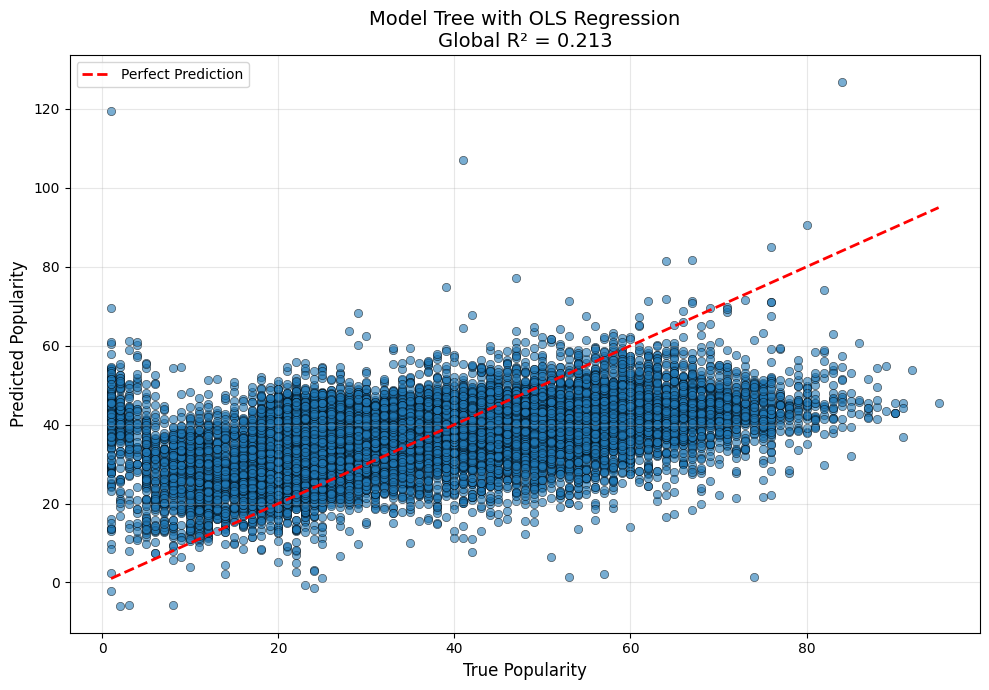

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Model Tree with OLS Regression\nGlobal R² = {r2:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()